<!--BOOK_INFORMATION-->
<img align="left" style="padding-right:10px;" src="figures/kep.png" height=75 width=75>
*This notebook uses routines from [PyKE](http://github.com/keplerGO/PyKE/) which is documented [here](http://pyke.keplerscience.org/). You can find these notebooks on [GitHub](https://github.com/christinahedges/k2torials)*

<!--NAVIGATION-->
< [Querying NExSci](01.02-Querying-NEXSci.ipynb) | [Contents](index.ipynb) | [What are Light Curve Files?](01.04-Investigating-LC-Files.ipynb) >

# Folding a Light Curve

Now that we can open a light curve file and plot a light curve, we are able to see the planet transit. In the file we opened in the last notebook the transit is large and clear. We should easily be able to find a period that would be useful to fold on. Let's redraw the light curve using PyKE.

Found the following flux columns: SAP_FLUX, SAP_FLUX_ERR, PDCSAP_FLUX, PDCSAP_FLUX_ERR
Using data column PDCSAP_FLUX on the plot...
Writing output file data/kplr006922244-2010078095331_llc-kepdraw.png...


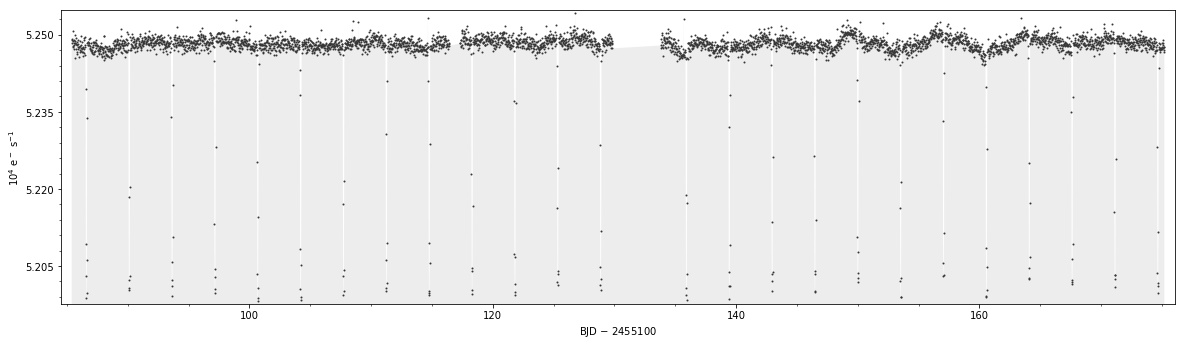

In [11]:
%matplotlib inline
from pyke import kepdraw
kepdraw('data/kplr006922244-2010078095331_llc.fits')

We'll go through finding the period and folding the light curve with two different approaches, firstly using python, and secondly using the command line.

## Python

Because the transit is so obvious and above the noise we are able to use a a simple period finding algorithm to find the transit period. We'll use *gatspy* to find the period. We'll use some bounds so that the period finding algorithm doesn't find spurious signals. The period for this planet should be between $\approx$0.2-10 days.

First off we'll import the data 

In [24]:
from astropy.io import fits
import numpy as np
h = fits.open('data/kplr006922244-2010078095331_llc.fits')
t,flux=h[1].data['TIME'],h[1].data['PDCSAP_FLUX']
#Remove NaN values
t,flux=t[np.isfinite(flux)],flux[np.isfinite(flux)]

And then use *gatspy* to find the best period

In [25]:
from gatspy import periodic
model = periodic.LombScargleFast(fit_period=True)
model.optimizer.quiet=True
model.optimizer.period_range = (0.2, 10)
model.fit(t, flux, flux.max()-flux.min())
per=model.best_period
print('Best Period: ',per)

Best Period:  1.76116955512


And finally we will fold the light curve. This can be done by simply taking the modulus of the time of each observation with the period we've found. 

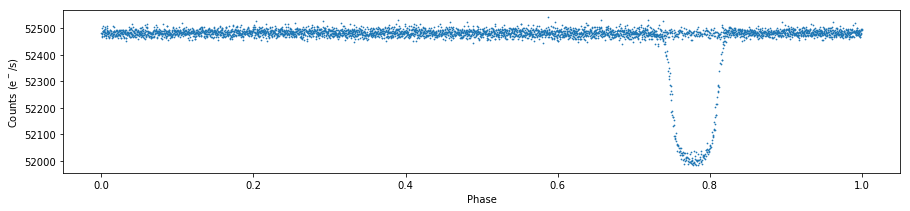

In [27]:
phase = t / per % 1
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(15,3))
plt.scatter(phase,flux,s=0.5)
plt.xlabel('Phase')
plt.ylabel('Counts (e$^-$/s)')

While this has folded to a harmonic of the correct period, this is actually half the period of the planet. Often algorithms will find a period that is half that of the true period, particularly due to deep secondary eclipses. We can rectify this by doubling the period

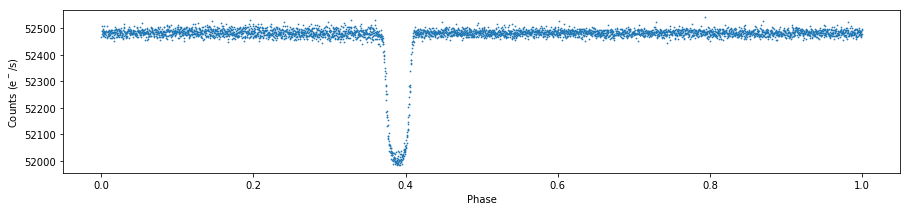

In [77]:
phase = t / (per*2) % 1

plt.figure(figsize=(15,3))
plt.scatter(phase,flux,s=0.5)
plt.xlabel('Phase')
plt.ylabel('Counts (e$^-$/s)')

## Bash/Command Line

Now we will use command line to do the same with PyKE. This time rather than using *gatspy* to create a quick period we will use a full BLS algorithm to find the period. This will be explained in more detail in a further notebook. We've set the minimum period and the maximum period to small values to save on time.

In [ ]:
%%bash
kepflatten data/kplr006922244-2010078095331_llc.fits --overwrite

In [169]:
%%bash
kepbls data/kplr006922244-2010078095331_llc-kepflatten.fits --minper 2 --maxper 4 --verbose --overwrite

Process is terminated.


In [170]:
%%bash
kepfold data/kplr006922244-2010078095331_llc-kepflatten-kepbls.fits

usage: kepfold [-h] [--outfile OUTFILE] [--bindata]
               [--binmethod {mean,median,sigclip}] [--threshold THRESHOLD]
               [--niter NITER] [--nbins NBINS] [--quality]
               [--plottype {sap,pdc,cbv,det,None}] [--overwrite] [--verbose]
               [--logfile LOGFILE]
               infile period bjd0
kepfold: error: the following arguments are required: period, bjd0


XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                   20 / length of dimension 1                          
NAXIS2  =                 1002 / length of dimension 2                          
PCOUNT  =                    0 / number of group parameters                     
GCOUNT  =                    1 / number of groups                               
TFIELDS =                    4 / number of table fields                         
TTYPE1  = 'PERIOD  '           / column title: trial period                     
TFORM1  = 'E       '           / column type: float32                           
TUNIT1  = 'days    '           / column units: days                             
TTYPE2  = 'BJD0    '           / column title: trial mid-transit zero-point     
TFORM2  = 'D       '        

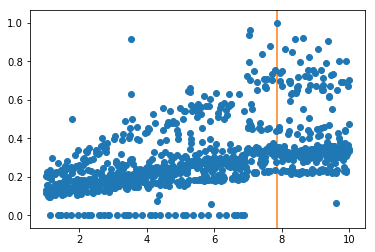

In [51]:
h = fits.open('data/kplr006922244-2010078095331_llc-kepbls.fits')
plt.scatter(h[3].data['PERIOD'],h[3].data['SIG_RES'])
plt.axvline(h[3].header['PERIOD'],c='C1',zorder=-1)
h[3].header

In [16]:
from pyke import kepbls
kepbls('data/kplr006922244-2010078095331_llc.fits',datacol='PDCSAP_FLUX',errcol='PDCSAP_FLUX_ERR',
      minper=1,maxper=10)

  0%|          | 0/1002 [00:00<?, ?it/s]

/Users/ch/K2/repos/PyKE/pyke/kepbls.py:212: RuntimeWarning: Mean of empty slice
  work4[i] = np.nanmean(phsort[elements, 1])
/Users/ch/K2/repos/PyKE/pyke/kepbls.py:214: RuntimeWarning: invalid value encountered in double_scalars
  / len(elements)))
100%|██████████| 1002/1002 [07:00<00:00,  2.38it/s]



Writing output file data/kplr006922244-2010078095331_llc-kepbls.fits...
      Best trial period = 7.866957187652588 days
    Time of mid-transit = BJD 2455188.952622697
       Transit duration = 0.6555797457695007 hours
 Maximum signal residue = 14.946466266601316 



The best period is $\approx$ 1.76 days. We can phase fold the light curve about this period so that we can see each transit occur at the same time.

In [6]:
from pyke import kepfold,kepflatten
%load_ext autoreload
%autoreload 2

--------------------------------------------------------------
KEPFOLD --  infile=data/kplr006922244-2010078095331_llc-kepflatten.fits outfile=data/kplr006922244-2010078095331_llc-kepflatten-kepfold.fits period=1.7611695551183704 bjd0=353.7670104816196 bindata=False binmethod=median threshold=1.0 niter=5 nbins=1000 rejqual=False plottype=sap overwrite=True verbose=True logfile=kepfold.log

KEPFOLD started at: Thu Oct 12 21:20:37 2017
Writing output file data/kplr006922244-2010078095331_llc-kepflatten-kepfold.fits...


100%|██████████| 4117/4117 [00:00<00:00, 97614.74it/s]


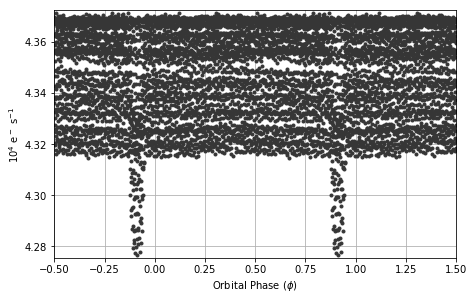

KEPFOLD ended at: : Thu Oct 12 21:20:37 2017


In [11]:
kepfold(infile='data/kplr006922244-2010078095331_llc-kepflatten.fits',period=per,bjd0=1.37025243313+t[0],overwrite=True,plottype='sap',verbose=True)

In [17]:
kepflatten(infile='data/kplr006922244-2010078095331_llc.fits',overwrite=True)

100%|██████████| 180/180 [00:03<00:00, 45.59it/s]


Writing output file data/kplr006922244-2010078095331_llc-kepflatten.fits...


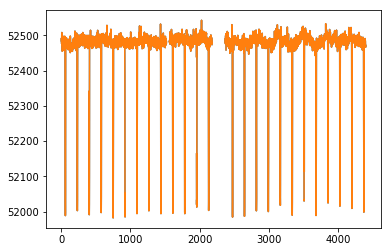

In [16]:
h = fits.open('data/kplr006922244-2010078095331_llc.fits')
plt.plot(h[1].data['PDCSAP_FLUX'])
h = fits.open('data/kplr006922244-2010078095331_llc-kepflatten.fits')
plt.plot(h[1].data['PDCSAP_FLUX'])

In [8]:
%%bash

kepflatten --help

usage: kepflatten [-h] [--outfile OUTFILE] [--datacol DATACOL]
                  [--errcol ERRCOL] [--nsig NSIG] [--stepsize STEPSIZE]
                  [--winsize WINSIZE] [--npoly NPOLY] [--niter NITER]
                  [--ranges RANGES] [--plot] [--overwrite] [--verbose]
                  [--logfile LOGFILE]
                  infile

Remove low frequency variability from time-series,preserve transits and flares

positional arguments:
  infile                Name of input file

optional arguments:
  -h, --help            show this help message and exit
  --outfile OUTFILE     Name of FITS file to output. If None, outfile is
                        infile-kepflatten. (default: None)
  --datacol DATACOL     Name of data column to plot (default: PDCSAP_FLUX)
  --errcol ERRCOL       Name of data error column to plot (default:
                        PDCSAP_FLUX_ERR)
  --nsig NSIG           Sigma clipping threshold for outliers (default: 3.0)
  --stepsize STEPSIZE   Stepsize on which to 

<!--NAVIGATION-->
< [Querying NExSci](01.02-Querying-NEXSci.ipynb) | [Contents](index.ipynb) | [What are Light Curve Files?](01.04-Investigating-LC-Files.ipynb) >